 ## Loading the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section

df = pd.read_json(
    "chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [2]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [3]:
# Extracting the prompt
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)
df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like j

In [4]:
#add columns to separate responses from the conversation (we already did this for the prompt)
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_a_response"][2]

'Both Fuji and Nikon are popular camera brands that offer a wide range of cameras for different types of photography. It really depends on your specific needs and preferences as to which brand is "better" for you.\n\nFujifilm is known for its high image quality, especially in the areas of color accuracy and dynamic range. Many photographers also appreciate the company\'s focus on ergonomics and the overall user experience of its cameras. Additionally, Fujifilm has a loyal following among enthusiasts and professional photographers, thanks to its commitment to film photography and its high-end mirrorless cameras.\n\nNikon, on the other hand, is known for its advanced autofocus system and image stabilization technology, as well as its high-end cameras and lenses. Nikon also has a wide selection of cameras and lenses to choose from, including both DSLR and mirrorless options.\n\nUltimately, it\'s difficult to say which brand is "better" without knowing more about your specific needs and pr

In [5]:
#create columns for prompt and response lengths
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe() #use this if you want to know statistics about prompt and response lengths

df["response_a_length"] = df["model_a_response"].str.len()


df["response_b_length"] = df["model_b_response"].str.len()


### Engineering feature of dot product similarity between embeddings

In [6]:
assert len(prompt_embeddings) == len(df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(df), "Mismatch between response_b embeddings and DataFrame rows."

# Compute dot products and add them as new columns to the original DataFrame
df['similarity_prompt_response_a'] = [
    np.dot(prompt, response_a)
    for prompt, response_a in zip(prompt_embeddings, response_a_embeddings)
]

df['similarity_prompt_response_b'] = [
    np.dot(prompt, response_b)
    for prompt, response_b in zip(prompt_embeddings, response_b_embeddings)
]


#### Converting the score_value_"n" columns, in topic_and_hardness dataframe, to numeric values and stored in the column "hardness_score"

In [7]:
#convert hardness scores from list to numeric
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [8]:
topic_and_hardness.drop_duplicates(subset='question_id', inplace=True)

In [9]:
#this will merge the mean value of the hardness scores and the topic_modeling 3 with the main data set
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')

#### Removing question ids that produce null values and storing the final dataset into filtered_df

In [10]:
# To Do: fetch code where we identified these question IDs @caroline
# This will remove question ids that produced null values for topic_and_hardness
filtered_df = merged_df[
    ~merged_df['question_id'].isin([
        'e6d45ead33114cca8ee3cfa028517eff',
        'addaa796ee094f029f8014ea1468df8a',
        'd37eb99864fa41ecab49026abdddb53e',
        '6da02001e74041d0947982fb4d05db9e',
        'd93e36df73e84aa2ade15d4a038c098f',
        '50b63f92bc5948218e1555d1eae17797',
        '8277b16d9a0845d694a33c04f446926c',
        'd56d698d4c1c495682a366f2a78fcb77',
        '86c7abedb5f84b7ea752cc98d324d387',
        '974569d7b9c74ca591f1922bf3722266',
        'ba3cfbae941946c6a41ea725b46f3aa7',
        '283be8724d674cb6a74da59d0c12ea16',
        'fbd400babd914eb1ad6202b4400d6beb',
        '087b90bf76ed4c409b7c7bd5d6b0d6c5',
        'f9ad250d0194489b8b9f12d31386aab1',
        '7e371a23981847c7b19bc61195f11eda',
        'f55b273603754c0d92f5139351ca0d02',
        '255e1466eaf14cc2ba93040776c0c440',
        '6979b646271e46f4a329a5e6acaeed38',
        'ed7fa335d5524295b1dd79452778d26c',
        'f794c699e4964b11a1373976be5b0944',
        'c92bcab701cc46649368fc121b84ccc1',
        'a632607132cf4908883fd262102714c9',
        'a0857d64b4954ea6bd75c2406c3dd32c',
        'e4a1fc8a9462475d95022914cb9f5b03',
        'c7aa752f61dc46d093dc86713686f6f3'
    ])
]


#### Calculating the ELO ratings per model:

In [11]:
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)




ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.688016
10                    gpt-4  1250.726993
11                claude-v1  1234.758964
19              guanaco-33b  1124.567221
9             gpt-3.5-turbo  1110.799361
3                vicuna-13b  1109.473792
14                   palm-2  1074.086047
2                 koala-13b  1069.641717
16                vicuna-7b  1050.621375
17             wizardlm-13b   997.391029
13              mpt-7b-chat   969.416715
12         RWKV-4-Raven-14B   937.085978
5                alpaca-13b   928.131634
18       gpt4all-13b-snoozy   926.279119
0                chatglm-6b   889.066656
1          oasst-pythia-12b   884.891087
4   stablelm-tuned-alpha-7b   839.718473
8            fastchat-t5-3b   827.172397
6                 llama-13b   773.750292
7              dolly-v2-12b   709.733134


### Create column where the ELO ratings are compared, model a minus model b, to give a measure of which model is stronger so that we can include the prompt features as well in task A (predicting whether model a or model b will win)

In [12]:
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

# Display the first few rows to verify the new column
filtered_df.columns

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/403063721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(


Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb'],
      dtype='object')

## Topics feature

In [13]:
# Define regex patterns and their corresponding feature names
core_topics = {
    r'math': 'topic_math',
    r'fact\w*': 'topic_fact',
    r'creativ\w*': 'topic_creative',
    r'problem[ -]?solving': 'topic_problem_solving'
}

# Apply one-hot encoding for the defined core topics
for pattern, feature_name in core_topics.items():
    filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)

# Check the updated DataFrame
filtered_df.head()

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/4182628651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int)
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/4182628651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[feature_name] = filtered_df['topic_modeling_3'].str.contains(pattern, case=False, na=False, regex=True).astype(int

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,response_b_length,similarity_prompt_response_a,similarity_prompt_response_b,hardness_score,topic_modeling_3,elo_modela_minus_modelb,topic_math,topic_fact,topic_creative,topic_problem_solving
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,1905,1.0,0.853198,8.666667,"Comparison, Technology",-180.575061,0,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,514,1.0,0.540338,8.333333,"Reasoning, Emotional",-43.240547,0,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,1566,1.0,0.851614,3.333333,Photography comparison,184.750630,0,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,1624,1.0,0.918109,8.000000,Chatbot Arena,224.582706,0,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,27,1.0,0.352887,2.000000,Time-based Inquiry,39.832075,0,0,0,0


## Auxiliary verbs feature

In [14]:
import re

# Define the modal verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Create a regex pattern (case-insensitive)
modal_regex = '|'.join([re.escape(verb) for verb in modal_verbs])

# Function to one-hot encode the presence of modal verbs
def one_hot_modal_features(df, column_name, modal_regex):
    for verb in modal_verbs:
        pattern = rf'\b{re.escape(verb)}\b'
        df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
    return df

# Apply the function to both model_a_response and model_b_response
filtered_df = one_hot_modal_features(filtered_df, 'model_a_response', modal_regex)
filtered_df = one_hot_modal_features(filtered_df, 'model_b_response', modal_regex)

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/3573132758.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/3573132758.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(i

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,model_b_response_contains_can,model_b_response_contains_could,model_b_response_contains_may,model_b_response_contains_might,model_b_response_contains_shall,model_b_response_contains_should,model_b_response_contains_will,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,1,0,0,0,0,0,0,0,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,0,1,0,0,0,0,0,1,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,0,0,1,0,0,0,1,0,0,0
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,1,1,0,0,0,1,1,0,0,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Question words feature

# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')

# Display the updated DataFrame with new features
filtered_df.head()


/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column_name}_contains_{word}'] = (
/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/398601605.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to,prompt_contains_who,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,0,0,0,0,0,0,0,1,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,1,0,0,0,0,0,1,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,0,0,0,0,0,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,0,0,0,0,0,0,0,0,1,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,0,0,0,0,1,0,0,0,0


In [16]:
filtered_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb', 'topic_math', 'topic_fact', 'topic_creative',
       'topic_problem_solving', 'model_a_response_contains_can',
       'model_a_response_contains_could', 'model_a_response_contains_may',
       'model_a_response_contains_might', 'model_a_response_contains_shall',
       'model_a_response_contains_should', 'model_a_response_contains_will',
       'model_a_response_contains_would', 'model_a_response_contains_must',
       'model_a_response_contains_have_to', 'model_b_response_contains_can',
       'model_b_response_contains_could', 'model_b_response_contains_may',
       'model_b_response_contains_might', 'model_b_response_

In [17]:
filtered_df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,model_b_response_contains_would,model_b_response_contains_must,model_b_response_contains_have_to,prompt_contains_who,prompt_contains_where,prompt_contains_when,prompt_contains_why,prompt_contains_what,prompt_contains_how,prompt_contains_which
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,0,0,0,0,0,0,0,1,0,0
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,1,0,0,0,0,0,1,0,0,0
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,0,0,0,0,0,0,0,0,0,1
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,0,0,0,0,0,0,0,0,1,0
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,0,0,0,0,1,0,0,0,0


In [18]:
filtered_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb', 'topic_math', 'topic_fact', 'topic_creative',
       'topic_problem_solving', 'model_a_response_contains_can',
       'model_a_response_contains_could', 'model_a_response_contains_may',
       'model_a_response_contains_might', 'model_a_response_contains_shall',
       'model_a_response_contains_should', 'model_a_response_contains_will',
       'model_a_response_contains_would', 'model_a_response_contains_must',
       'model_a_response_contains_have_to', 'model_b_response_contains_can',
       'model_b_response_contains_could', 'model_b_response_contains_may',
       'model_b_response_contains_might', 'model_b_response_

In [19]:
filtered_df['hardness_score']

0        8.666667
1        8.333333
2        3.333333
3        8.000000
4        2.000000
           ...   
25277    7.333333
25278    2.000000
25279    8.000000
25280    7.666667
25281    8.666667
Name: hardness_score, Length: 25256, dtype: float64

In [20]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer


In [21]:
# Ensure you are working on a copy of the DataFrame to avoid chained assignment
filtered_df = filtered_df.copy()

# Feature engineering: interaction term
filtered_df.loc[:, 'length_interaction'] = (
    filtered_df['response_a_length'] * filtered_df['response_b_length']  # Multiply lengths to capture interaction
)

# Feature engineering: counting modal verbs in model A's responses
filtered_df.loc[:, 'model_a_modal_count'] = filtered_df.filter(like='model_a_response_contains').sum(axis=1)

# Feature engineering: counting modal verbs in model B's responses
filtered_df.loc[:, 'model_b_modal_count'] = filtered_df.filter(like='model_b_response_contains').sum(axis=1)

# Sentiment analysis on the prompt
filtered_df.loc[:, 'prompt_sentiment'] = filtered_df['prompt'].apply(lambda x: TextBlob(x).sentiment.polarity)
filtered_df.loc[:, 'prompt_subjectivity'] = filtered_df['prompt'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [22]:
# Preprocess text columns to handle non-string values
def preprocess_text_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(
            lambda x: ' '.join([f"{key}: {value}" for key, value in x.items()])
            if isinstance(x, dict)
            else ' '.join(map(str, x))
            if isinstance(x, list)
            else str(x)
        )
    return df

# Columns that may contain non-string values
text_columns = ['conversation_a', 'conversation_b', 'prompt']

# Preprocess the text columns
filtered_df = preprocess_text_columns(filtered_df, text_columns)

# Apply your existing feature engineering code
# Sentiment and subjectivity features
filtered_df['response_a_sentiment'] = filtered_df['conversation_a'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)
filtered_df['response_b_sentiment'] = filtered_df['conversation_b'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

# Similarly for subjectivity if needed
filtered_df['response_a_subjectivity'] = filtered_df['conversation_a'].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)
filtered_df['response_b_subjectivity'] = filtered_df['conversation_b'].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)



In [23]:
# Check for non-string values in text columns
for col in text_columns:
    non_string_values = filtered_df[col].apply(lambda x: not isinstance(x, str)).sum()
    print(f"Non-string values in {col}: {non_string_values}")


Non-string values in conversation_a: 0
Non-string values in conversation_b: 0
Non-string values in prompt: 0


In [24]:
filtered_df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,model_a_response,model_b_response,...,prompt_contains_which,length_interaction,model_a_modal_count,model_b_modal_count,prompt_sentiment,prompt_subjectivity,response_a_sentiment,response_b_sentiment,response_a_subjectivity,response_b_subjectivity
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,{'content': 'What is the difference between Op...,{'content': 'What is the difference between Op...,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,...,0,1699260,1,1,0.0,0.0,0.197685,0.053125,0.343519,0.454167
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,{'content': 'Why did my parent not invite me t...,{'content': 'Why did my parent not invite me t...,Why did my parent not invite me to their wedding?,It is possible that your parent did not invite...,It is likely that they wanted to keep the gues...,...,0,339240,2,2,0.0,0.0,0.379167,0.192857,0.745833,0.728571
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"{'content': 'Fuji vs. Nikon, which is better?'...","{'content': 'Fuji vs. Nikon, which is better?'...","Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,...,1,1744524,1,2,0.5,0.5,0.133397,0.240724,0.437115,0.464683
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,{'content': 'How to build an arena for chatbot...,{'content': 'How to build an arena for chatbot...,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,...,0,2557800,4,4,0.0,0.0,0.148016,0.196154,0.359061,0.428541
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"{'content': 'When is it today?', 'role': 'user...","{'content': 'When is it today?', 'role': 'user...",When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",...,0,7209,1,0,0.0,0.0,-0.166667,0.000000,0.600000,0.000000


In [25]:
from textblob import TextBlob

def extract_textblob_features(df, text_column):
    polarity = []
    subjectivity = []
    noun_count = []
    verb_count = []
    adj_count = []

    for text in df[text_column]:
        # Create TextBlob object
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
        noun_count.append(len([word for word, pos in blob.tags if pos.startswith('NN')]))  # Count nouns
        verb_count.append(len([word for word, pos in blob.tags if pos.startswith('VB')]))  # Count verbs
        adj_count.append(len([word for word, pos in blob.tags if pos.startswith('JJ')]))  # Count adjectives

    # Add extracted features to the DataFrame
    df[f"{text_column}_polarity"] = polarity
    df[f"{text_column}_subjectivity"] = subjectivity
    df[f"{text_column}_noun_count"] = noun_count
    df[f"{text_column}_verb_count"] = verb_count
    df[f"{text_column}_adj_count"] = adj_count

    return df

# Apply to prompts and responses
filtered_df = extract_textblob_features(filtered_df, 'prompt')
filtered_df = extract_textblob_features(filtered_df, 'model_a_response')
filtered_df = extract_textblob_features(filtered_df, 'model_b_response')

# Generate additional word counts
filtered_df['prompt_word_count'] = filtered_df['prompt'].apply(lambda x: len(TextBlob(x).words))
filtered_df['model_a_word_count'] = filtered_df['model_a_response'].apply(lambda x: len(TextBlob(x).words))
filtered_df['model_b_word_count'] = filtered_df['model_b_response'].apply(lambda x: len(TextBlob(x).words))


In [26]:
# additional features for task b

filtered_df['length_interaction'] = (
    filtered_df['response_a_length'] * filtered_df['response_b_length']
)
# Interaction between polarity and subjectivity
filtered_df['prompt_polarity_subjectivity'] = (
    filtered_df['prompt_polarity'] * filtered_df['prompt_subjectivity']
)


# Interaction between response lengths and sentiment polarity
filtered_df['response_a_length_polarity'] = (
    filtered_df['response_a_length'] * filtered_df['model_a_response_polarity'])
filtered_df['response_b_length_polarity'] = (
    filtered_df['response_b_length'] * filtered_df['model_b_response_polarity'])

filtered_df['polarity_difference'] = (
    filtered_df['model_a_response_polarity'] - filtered_df['model_b_response_polarity']
)
filtered_df['subjectivity_difference'] = (
    filtered_df['model_a_response_subjectivity'] - filtered_df['model_b_response_subjectivity']
)


filtered_df['model_a_modal_count'] = filtered_df.filter(like='model_a_response_contains').sum(axis=1)
filtered_df['model_b_modal_count'] = filtered_df.filter(like='model_b_response_contains').sum(axis=1)

In [27]:
filtered_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb', 'topic_math', 'topic_fact', 'topic_creative',
       'topic_problem_solving', 'model_a_response_contains_can',
       'model_a_response_contains_could', 'model_a_response_contains_may',
       'model_a_response_contains_might', 'model_a_response_contains_shall',
       'model_a_response_contains_should', 'model_a_response_contains_will',
       'model_a_response_contains_would', 'model_a_response_contains_must',
       'model_a_response_contains_have_to', 'model_b_response_contains_can',
       'model_b_response_contains_could', 'model_b_response_contains_may',
       'model_b_response_contains_might', 'model_b_response_

In [28]:
prompt_embeddings = prompt_embeddings[:len(filtered_df)]
response_a_embeddings = response_a_embeddings[:len(filtered_df)]
response_b_embeddings = response_b_embeddings[:len(filtered_df)]


 'model_a_response_noun_count',
       'model_a_response_verb_count', 'model_a_response_adj_count',
       'model_b_response_polarity',
       'model_b_response_noun_count', 'model_b_response_verb_count',
       'model_b_response_adj_count', 'model_a_response_noun_count',
       'model_a_response_verb_count', 'model_a_response_adj_count',  'model_a_response_noun_count', 'prompt_noun_count', 'prompt_verb_count',

selected_features = ['prompt_length',
    'length_interaction', 'elo_modela_minus_modelb',
    'prompt_noun_count', 'prompt_verb_count', 
    'response_a_length_polarity', 'response_b_length_polarity',
    'model_a_response_noun_count', 'model_a_response_verb_count',
    'model_b_response_noun_count', 'model_b_response_verb_count', 'topic_math', 'topic_creative']

In [81]:
selected_features = [
       'prompt_length', 'response_a_length',
       'response_b_length',
       'elo_modela_minus_modelb',
       'length_interaction',
       'prompt_sentiment', 'prompt_subjectivity', 'response_a_sentiment',
       'response_b_sentiment', 'prompt_polarity',
       'prompt_verb_count', 'model_a_response_polarity',
       'model_b_response_polarity', 'prompt_word_count', 'model_a_word_count',
       'model_b_word_count', 'response_a_length_polarity',
       'response_b_length_polarity', 'polarity_difference',
       'subjectivity_difference', 'prompt_polarity_subjectivity']

<Axes: >

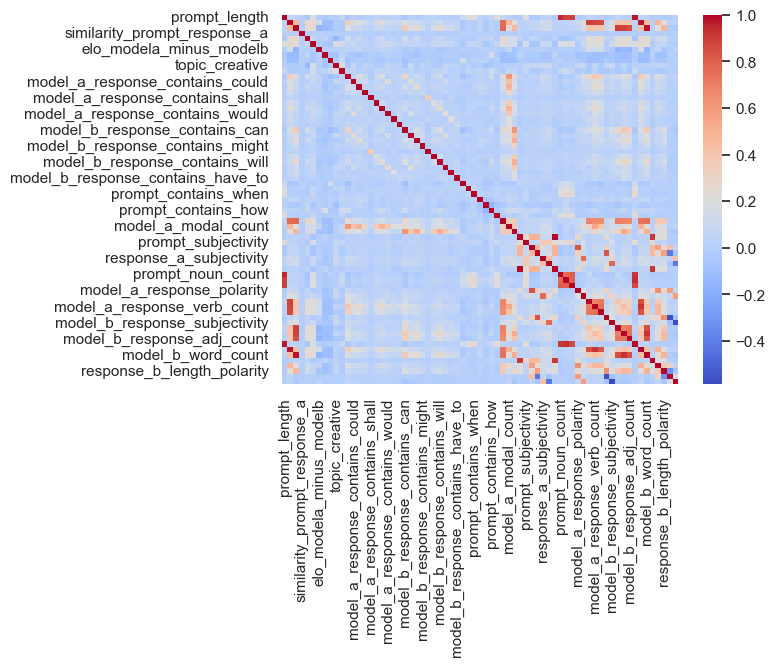

In [82]:
numeric_df = filtered_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, cmap='coolwarm')

In [83]:
# ensure y is cleaned first
y = filtered_df['hardness_score']
y = y.dropna()  # drop NaN values
y = y[~np.isinf(y)]  # drop inf values

# ensure X aligns with cleaned y
X = filtered_df[selected_features].loc[y.index]

# drop missing or infinite values in X
X = X.dropna()
#X = X[~np.isinf(X).any(axis=1)]

# aligns X and y indices after filtering
X, y = X.align(y, axis=0)


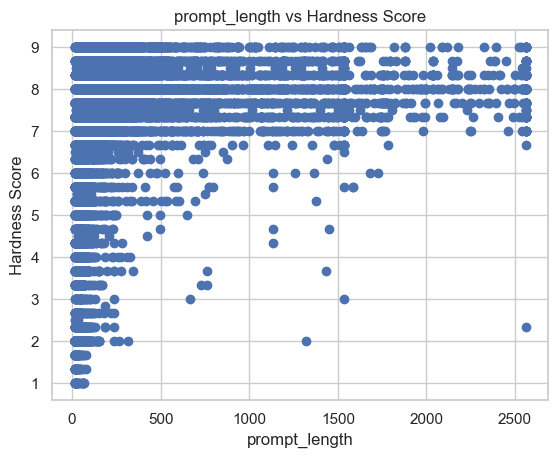

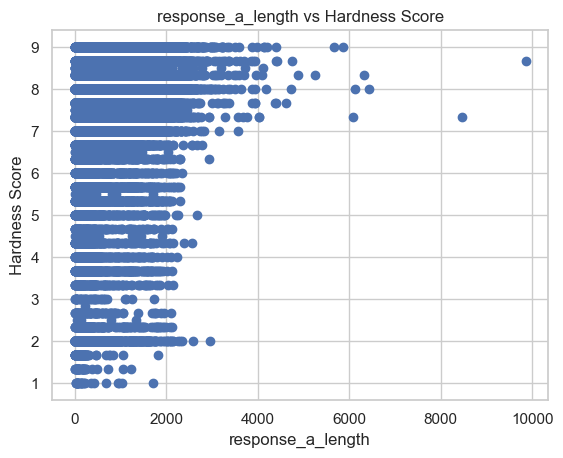

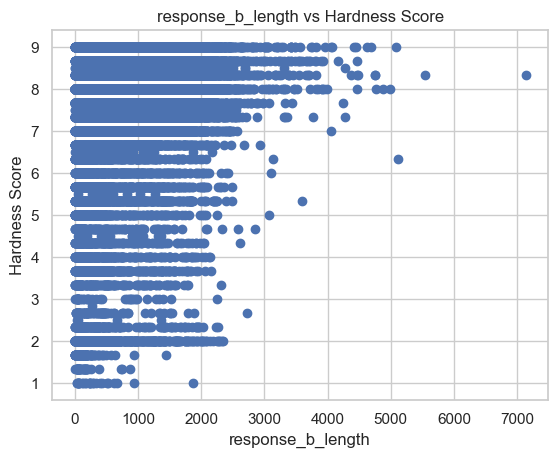

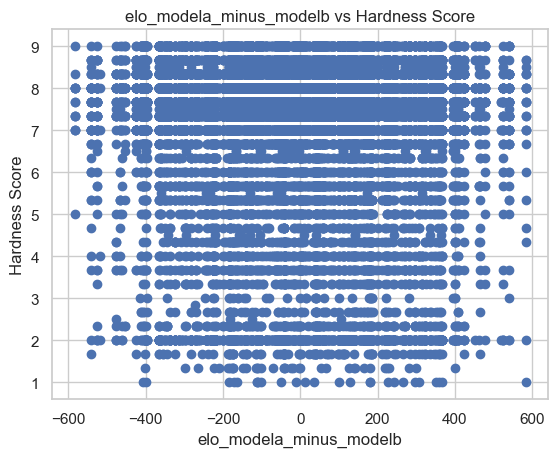

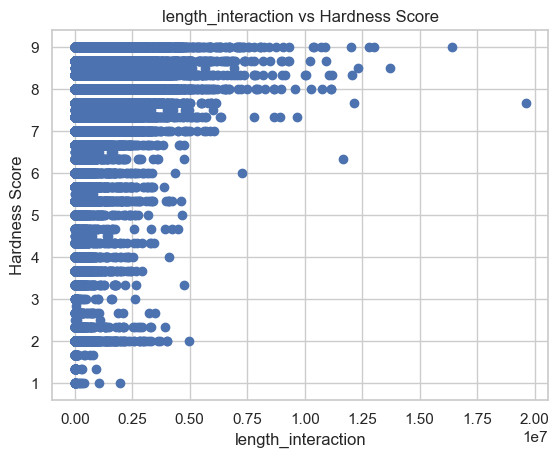

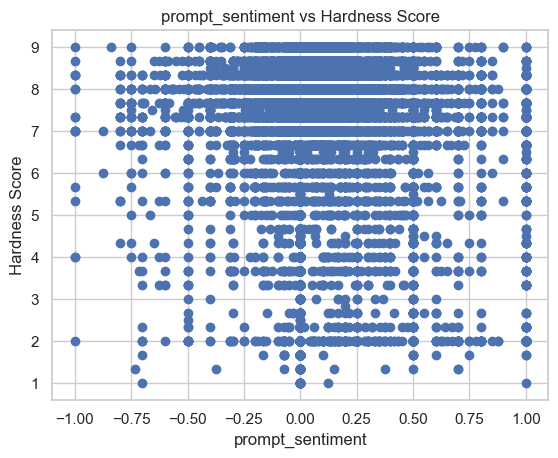

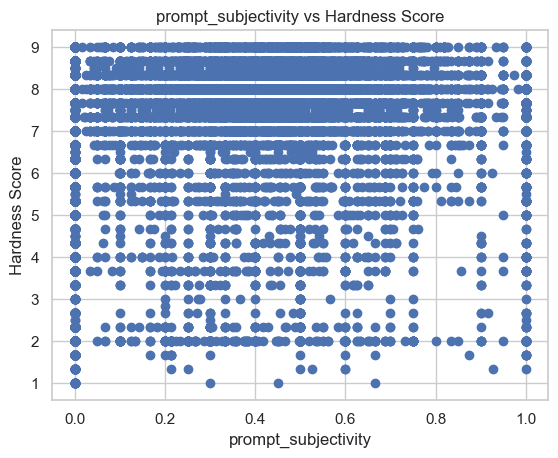

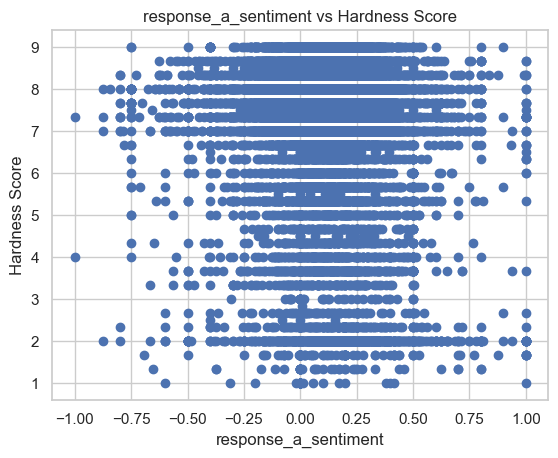

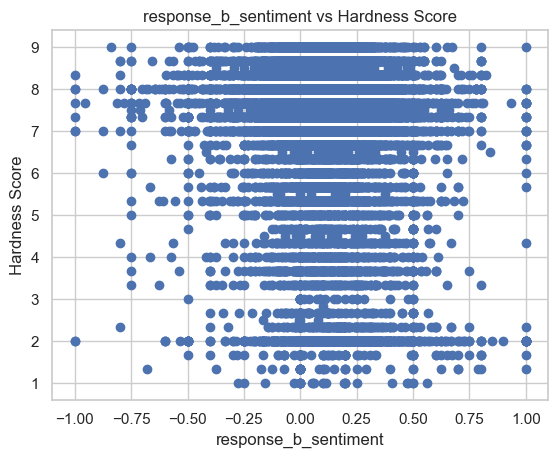

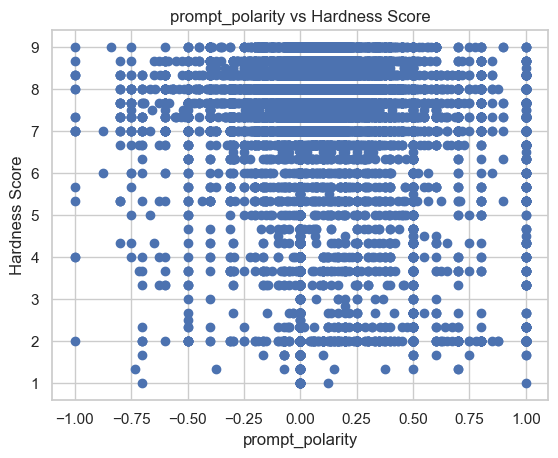

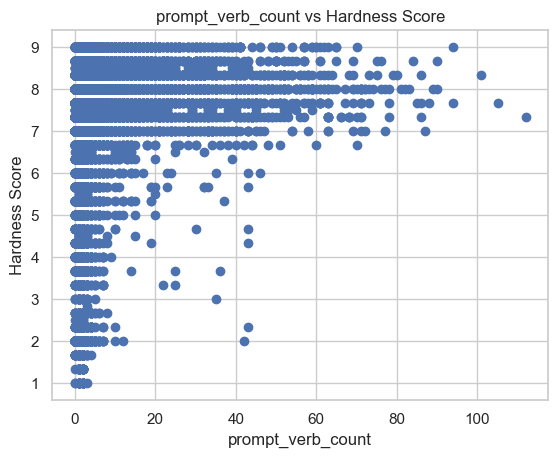

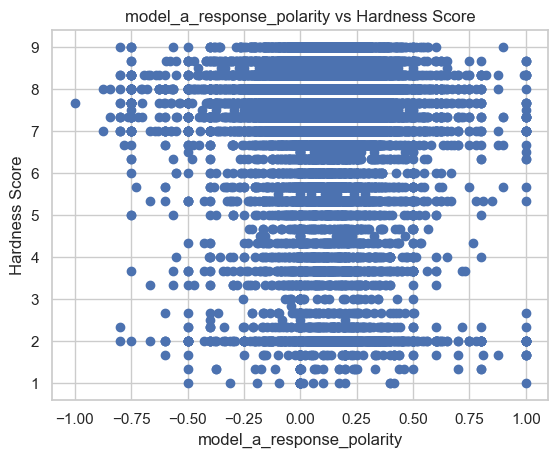

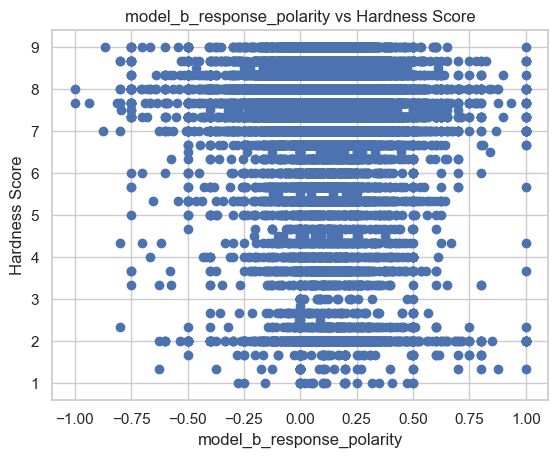

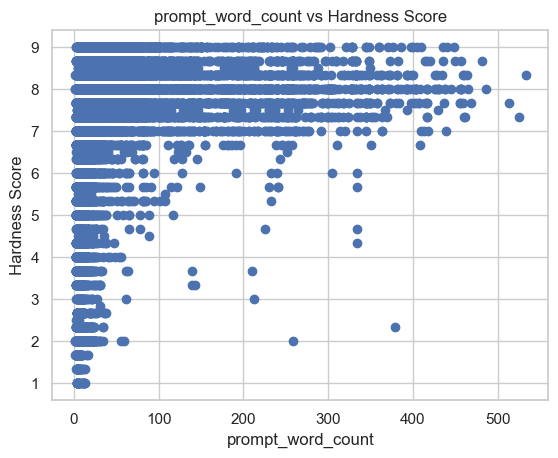

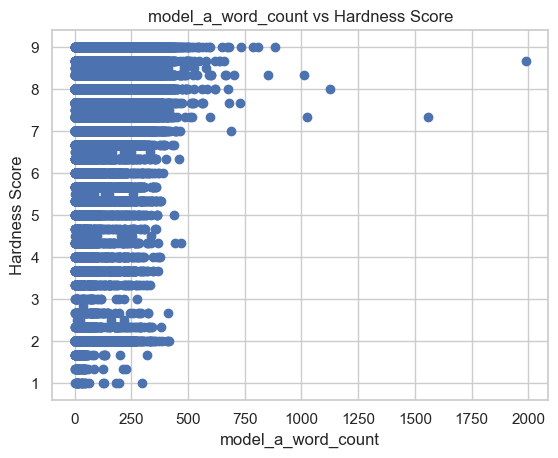

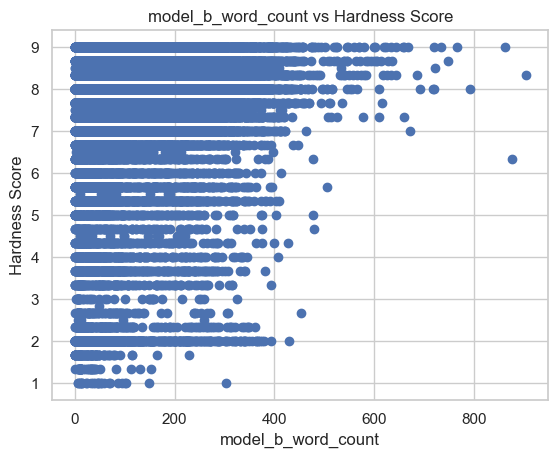

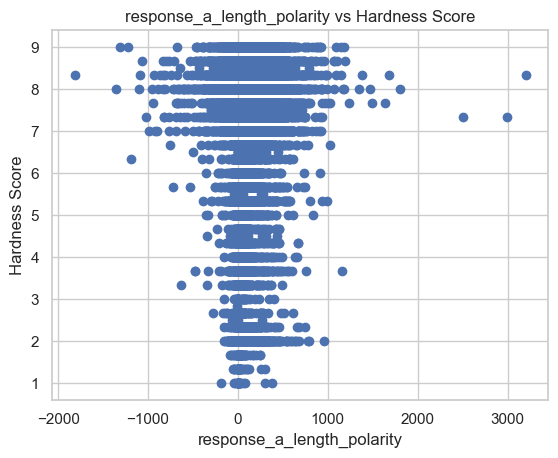

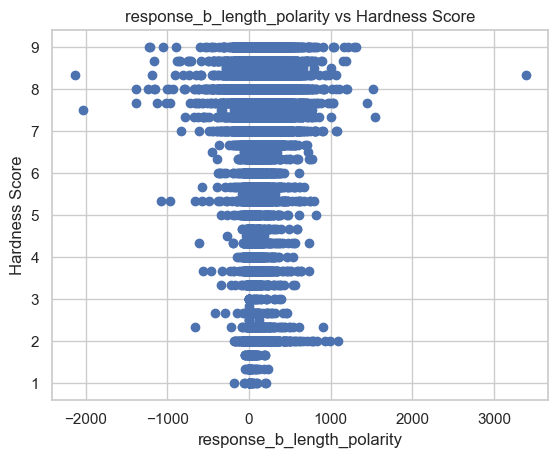

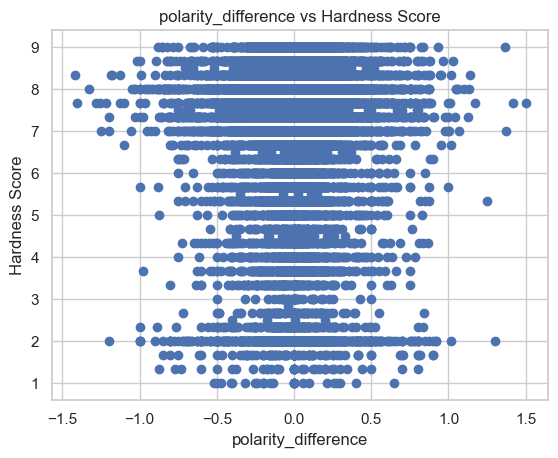

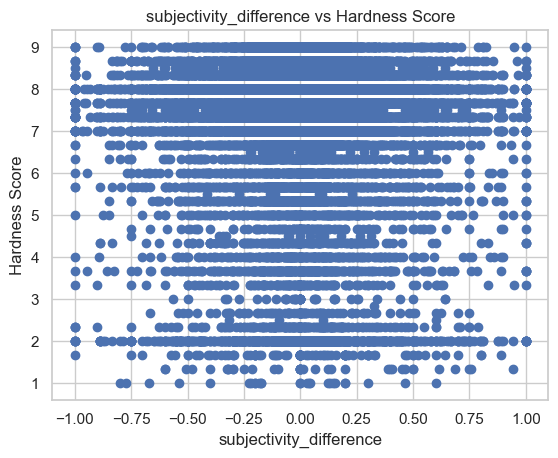

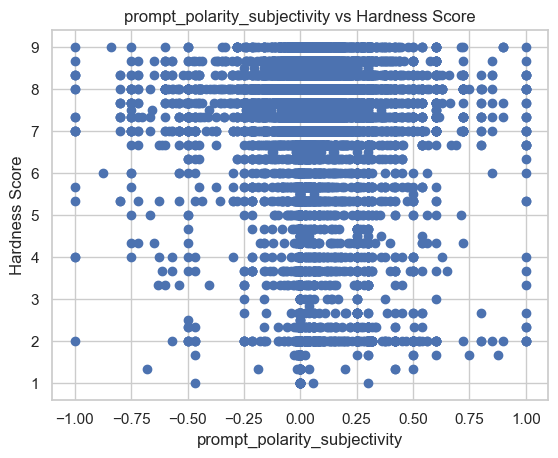

In [84]:
import matplotlib.pyplot as plt
for column in X.columns:
    plt.scatter(X[column], y)
    plt.title(f"{column} vs Hardness Score")
    plt.xlabel(column)
    plt.ylabel("Hardness Score")
    plt.show()


In [66]:
filtered_df.columns

Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'model_a_response',
       'model_b_response', 'prompt_length', 'response_a_length',
       'response_b_length', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'elo_modela_minus_modelb', 'topic_math', 'topic_fact', 'topic_creative',
       'topic_problem_solving', 'model_a_response_contains_can',
       'model_a_response_contains_could', 'model_a_response_contains_may',
       'model_a_response_contains_might', 'model_a_response_contains_shall',
       'model_a_response_contains_should', 'model_a_response_contains_will',
       'model_a_response_contains_would', 'model_a_response_contains_must',
       'model_a_response_contains_have_to', 'model_b_response_contains_can',
       'model_b_response_contains_could', 'model_b_response_contains_may',
       'model_b_response_contains_might', 'model_b_response_

In [67]:
# Function for oversampling low-range data
def oversample_low_range(X, y, low_threshold=3):
    """
    Oversample the low-range target values to address class imbalance.
    
    Parameters:
    - X: Features (DataFrame)
    - y: Target variable (Series)
    - low_threshold: Threshold to define the low range
    
    Returns:
    - X_combined: Oversampled features
    - y_combined: Oversampled target variable
    """
    low_range = y <= low_threshold
    X_low, y_low = X[low_range], y[low_range]

    # If no low-range samples exist, return original data
    if X_low.empty or y_low.empty:
        print("Warning: No low-range data available for oversampling.")
        return X, y

    # Oversample low-range data
    X_oversampled, y_oversampled = resample(
        X_low, y_low,
        replace=True,  # Oversampling with replacement
        n_samples=X.shape[0] // 3,  # Target size of oversampling
        random_state=42
    )

    # Combine oversampled data with the original dataset
    X_combined = pd.concat([X, X_oversampled])
    y_combined = pd.concat([y, y_oversampled])

    return X_combined, y_combined

In [68]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    explained_variance_score, r2_score
)
def calculate_performance_metrics(y_true, y_pred, y_train=None, y_train_pred=None, y_val=None, y_val_pred=None):
    """
    Calculates various performance metrics for training, testing, and validation sets.
    
    Parameters:
    - y_true: True values for the test set.
    - y_pred: Predicted values for the test set.
    - y_train: True values for the training set (optional).
    - y_train_pred: Predicted values for the training set (optional).
    - y_val: True values for the validation set (optional).
    - y_val_pred: Predicted values for the validation set (optional).
    
    Returns:
    - metrics: Dictionary containing performance metrics.
    """
    metrics = {
        "Test RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "Test MSE": mean_squared_error(y_true, y_pred),
        "Test MAE": mean_absolute_error(y_true, y_pred),
        "Test R² Score": r2_score(y_true, y_pred),
        "Test Explained Variance": explained_variance_score(y_true, y_pred),
        "Test Residual Std Dev": np.std(y_true - y_pred),
    }
    
    if y_train is not None and y_train_pred is not None:
        metrics.update({
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
            "Train MSE": mean_squared_error(y_train, y_train_pred),
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Train R² Score": r2_score(y_train, y_train_pred),
            "Train Explained Variance": explained_variance_score(y_train, y_train_pred),
        })
    
    if y_val is not None and y_val_pred is not None:
        metrics.update({
            "Validation RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred)),
            "Validation MSE": mean_squared_error(y_val, y_val_pred),
            "Validation MAE": mean_absolute_error(y_val, y_val_pred),
            "Validation R² Score": r2_score(y_val, y_val_pred),
            "Validation Explained Variance": explained_variance_score(y_val, y_val_pred),
        })
    
    return metrics

# Function to display performance metrics
def display_performance_metrics(metrics):
    """
    Display performance metrics in a readable format.
    
    Parameters:
    - metrics: Dictionary of performance metrics to display.
    """
    print("\nPerformance Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.2f}")


In [69]:
 #function to calculate range-specific RMSE
def calculate_range_rmse(y_true, y_pred, low_threshold=3, mid_threshold=6):
    y_pred_rounded = np.round(y_pred)
    rmse_low = np.sqrt(mean_squared_error(y_true[y_true <= low_threshold], y_pred_rounded[y_true <= low_threshold])) if (y_true <= low_threshold).sum() > 0 else np.nan
    rmse_mid = np.sqrt(mean_squared_error(y_true[(y_true > low_threshold) & (y_true <= mid_threshold)], y_pred_rounded[(y_true > low_threshold) & (y_true <= mid_threshold)])) if ((y_true > low_threshold) & (y_true <= mid_threshold)).sum() > 0 else np.nan
    rmse_high = np.sqrt(mean_squared_error(y_true[y_true > mid_threshold], y_pred_rounded[y_true > mid_threshold])) if (y_true > mid_threshold).sum() > 0 else np.nan
    return rmse_low, rmse_mid, rmse_high

# function to display range-specific RMSE
def display_range_rmse(rmse_low, rmse_mid, rmse_high):
    print("\nRange-Specific RMSE:")
    print(f"Low Range (<=3): {rmse_low:.2f}" if not np.isnan(rmse_low) else "Low Range (<=3): N/A")
    print(f"Mid Range (3-6): {rmse_mid:.2f}" if not np.isnan(rmse_mid) else "Mid Range (3-6): N/A")
    print(f"High Range (>6): {rmse_high:.2f}" if not np.isnan(rmse_high) else "High Range (>6): N/A")


In [70]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=['hardness_score'])

# Extract features and target variable
X = filtered_df[selected_features]
y = filtered_df['hardness_score']

# Oversample the low range 0-3
X_oversampled, y_oversampled = oversample_low_range(X, y)

# K-Fold Cross-Validation and Random Forest Regressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Storing all the metrics
rmse_scores_low, rmse_scores_mid, rmse_scores_high = [], [], []
training_scores, validation_scores = [], []
training_mse, validation_mse = [], []
training_mae, validation_mae = [], []
y_true_all, y_pred_all = [], []

# K-Fold Cross-Validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X_oversampled), 1):
    print(f"Processing Fold {fold}...")
    
    X_train, X_test = X_oversampled.iloc[train_idx], X_oversampled.iloc[test_idx]
    y_train, y_test = y_oversampled.iloc[train_idx], y_oversampled.iloc[test_idx]

    # Train model
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    y_pred_test_rounded = np.round(y_pred_test)

    # True and predicted values for plotting
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test_rounded)

    # Training and validation R^2 scores calculations
    training_scores.append(rf_model.score(X_train, y_train))
    validation_scores.append(rf_model.score(X_test, y_test))

    # Training and validation MSE/MAE
    training_mse.append(mean_squared_error(y_train, y_pred_train))
    validation_mse.append(mean_squared_error(y_test, y_pred_test))
    training_mae.append(mean_absolute_error(y_train, y_pred_train))
    validation_mae.append(mean_absolute_error(y_test, y_pred_test))

    # Calculate RMSE for each range
    rmse_low, rmse_mid, rmse_high = calculate_range_rmse(y_test, y_pred_test)
    if not np.isnan(rmse_low): rmse_scores_low.append(rmse_low)
    if not np.isnan(rmse_mid): rmse_scores_mid.append(rmse_mid)
    if not np.isnan(rmse_high): rmse_scores_high.append(rmse_high)

# Calculate metrics
average_metrics = calculate_performance_metrics(np.array(y_true_all), np.array(y_pred_all))
rmse_low_avg = np.mean(rmse_scores_low)
rmse_mid_avg = np.mean(rmse_scores_mid)
rmse_high_avg = np.mean(rmse_scores_high)

# Display the metrics
display_performance_metrics(average_metrics)
display_range_rmse(rmse_low_avg, rmse_mid_avg, rmse_high_avg)

# Display training and validation metrics
print("\nTraining and Validation Metrics (Averages Across Folds):")
print(f"Training R²: {np.mean(training_scores):.2f}")
print(f"Validation R²: {np.mean(validation_scores):.2f}")
print(f"Training MSE: {np.mean(training_mse):.2f}")
print(f"Validation MSE: {np.mean(validation_mse):.2f}")
print(f"Training MAE: {np.mean(training_mae):.2f}")
print(f"Validation MAE: {np.mean(validation_mae):.2f}")

Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

Performance Metrics:
Test RMSE: 1.06
Test MSE: 1.12
Test MAE: 0.66
Test R² Score: 0.84
Test Explained Variance: 0.85
Test Residual Std Dev: 1.03

Range-Specific RMSE:
Low Range (<=3): 0.40
Mid Range (3-6): 1.74
High Range (>6): 1.15

Training and Validation Metrics (Averages Across Folds):
Training R²: 0.97
Validation R²: 0.85
Training MSE: 0.21
Validation MSE: 1.05
Training MAE: 0.30
Validation MAE: 0.65


In [86]:
print (y_pred_test_rounded)

[4. 5. 7. ... 8. 6. 7.]


In [60]:
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print(feature_importances.sort_values(ascending=False))

prompt_length                  0.466753
length_interaction             0.154605
response_a_length_polarity     0.069209
response_b_length_polarity     0.065198
model_a_response_noun_count    0.048743
model_b_response_noun_count    0.047166
topic_creative                 0.045327
model_a_response_verb_count    0.045066
model_b_response_verb_count    0.041632
topic_math                     0.016301
dtype: float64


In [71]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=['hardness_score'])

# Extract features and target variable
X = filtered_df[selected_features]
y = filtered_df['hardness_score']

# K-Fold Cross-Validation and Random Forest Regressor
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Storing all the metrics
rmse_scores_low, rmse_scores_mid, rmse_scores_high = [], [], []
training_scores, validation_scores = [], []
training_mse, validation_mse = [], []
training_mae, validation_mae = [], []
y_true_all, y_pred_all = [], []

# K-Fold Cross-Validation loop
for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    print(f"Processing Fold {fold}...")
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train model
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    y_pred_test_rounded = np.round(y_pred_test)

    # True and predicted values for plotting
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred_test_rounded)

    # Training and validation R² scores calculations
    training_scores.append(rf_model.score(X_train, y_train))
    validation_scores.append(rf_model.score(X_test, y_test))

    # Training and validation MSE/MAE
    training_mse.append(mean_squared_error(y_train, y_pred_train))
    validation_mse.append(mean_squared_error(y_test, y_pred_test))
    training_mae.append(mean_absolute_error(y_train, y_pred_train))
    validation_mae.append(mean_absolute_error(y_test, y_pred_test))

    # Calculate RMSE for each range
    rmse_low, rmse_mid, rmse_high = calculate_range_rmse(y_test, y_pred_test)
    if not np.isnan(rmse_low): rmse_scores_low.append(rmse_low)
    if not np.isnan(rmse_mid): rmse_scores_mid.append(rmse_mid)
    if not np.isnan(rmse_high): rmse_scores_high.append(rmse_high)

# Calculate metrics
average_metrics = calculate_performance_metrics(np.array(y_true_all), np.array(y_pred_all))
rmse_low_avg = np.mean(rmse_scores_low)
rmse_mid_avg = np.mean(rmse_scores_mid)
rmse_high_avg = np.mean(rmse_scores_high)

# Display overall metrics
print("\nOverall Metrics:")
display_performance_metrics(average_metrics)

# Display RMSE by range
display_range_rmse(rmse_low_avg, rmse_mid_avg, rmse_high_avg)

# Display training and validation metrics
print("\nTraining and Validation Metrics (Averages Across Folds):")
print(f"Training R²: {np.mean(training_scores):.2f}")
print(f"Validation R²: {np.mean(validation_scores):.2f}")
print(f"Training MSE: {np.mean(training_mse):.2f}")
print(f"Validation MSE: {np.mean(validation_mse):.2f}")
print(f"Training MAE: {np.mean(training_mae):.2f}")
print(f"Validation MAE: {np.mean(validation_mae):.2f}")


Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

Overall Metrics:

Performance Metrics:
Test RMSE: 1.36
Test MSE: 1.84
Test MAE: 0.93
Test R² Score: 0.38
Test Explained Variance: 0.38
Test Residual Std Dev: 1.36

Range-Specific RMSE:
Low Range (<=3): 3.26
Mid Range (3-6): 1.80
High Range (>6): 0.99

Training and Validation Metrics (Averages Across Folds):
Training R²: 0.92
Validation R²: 0.40
Training MSE: 0.25
Validation MSE: 1.77
Training MAE: 0.34
Validation MAE: 0.92


In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error

# Custom RMSE scorer for GridSearchCV
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the parameter grid for regularization
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=kf,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the data
grid_search.fit(X_oversampled, y_oversampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the dataset
best_model = grid_search.best_estimator_

# Predictions and metrics
y_pred = best_model.predict(X_oversampled)
rmse_score = rmse(y_oversampled, y_pred)
print(f"RMSE with Best Hyperparameters: {rmse_score:.2f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   4.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END max_depth=10, min_samples_

<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

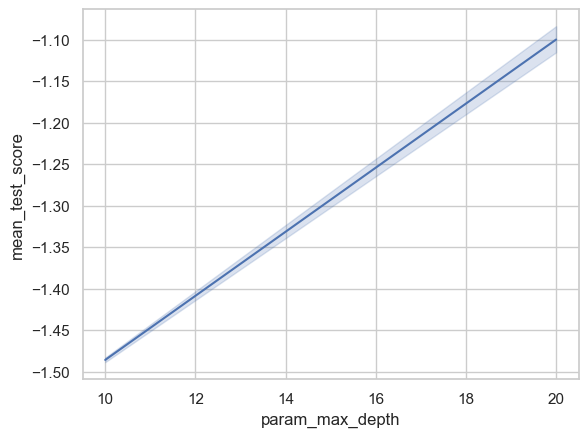

In [41]:
results = pd.DataFrame(grid_search.cv_results_)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=results)

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function for scatter plot: True vs Predicted Values
def plot_true_vs_predicted(performance_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='True Values', y='Predicted Values', data=performance_df, alpha=0.7)
    plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
             [performance_df['True Values'].min(), performance_df['True Values'].max()],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.title('True vs Predicted Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Predicted Hardness Scores')
    plt.legend()
    plt.show()

# Function for residual plots
def plot_residuals(performance_df):
    residuals = performance_df['True Values'] - performance_df['Predicted Values']
    # Histogram of residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals (True - Predicted)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    # Residual scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=performance_df['True Values'], y=residuals, alpha=0.7, color='blue')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
    plt.title('Residuals vs True Values')
    plt.xlabel('True Hardness Scores')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

# Function for error analysis
def plot_error_by_range(performance_df):
    performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
    performance_df['Range'] = pd.cut(performance_df['True Values'], bins=[0, 3, 6, 10], labels=['Low', 'Mid', 'High'])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Range', y='Error', data=performance_df, palette='viridis')
    plt.title('Prediction Errors by Hardness Range')
    plt.xlabel('Hardness Score Range')
    plt.ylabel('Error')
    plt.show()

# Function for feature importance plot
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Function for correlation heatmap
def plot_correlation_heatmap(data, features):
    corr_matrix = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Heatmap')
    plt.show()

def plot_hardness_score_distributions(filtered_df, y_pred, true_col='hardness_score', pred_col_name='Predicted Hardness Score'):
    """
    Plots the distributions of true and predicted hardness scores.

    Parameters:
    - filtered_df: DataFrame containing the true hardness scores.
    - y_pred: Predicted hardness scores as a list or array.
    - true_col: Name of the column in filtered_df with true hardness scores. Default is 'hardness_score'.
    - pred_col_name: Label for the predicted hardness scores in the second plot.
    """
    # Plot the distribution of true hardness scores
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df[true_col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Hardness Scores', fontsize=16)
    plt.xlabel('Hardness Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot the distribution of predicted hardness scores
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred, bins=30, color='green', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {pred_col_name}', fontsize=16)
    plt.xlabel(pred_col_name, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_training_vs_testing_performance(train_errors, test_errors, metric_name="RMSE"):
    """
    Plot training vs. testing performance across K-Folds or epochs.

    Parameters:
    - train_errors: List of errors (e.g., RMSE, MSE) for the training set across folds/epochs.
    - test_errors: List of errors for the testing set across folds/epochs.
    - metric_name: Name of the metric being evaluated (default is "RMSE").
    """
    folds = range(1, len(train_errors) + 1)

    # Line plot of training vs testing errors
    plt.figure(figsize=(10, 6))
    plt.plot(folds, train_errors, label='Training Error', marker='o', color='blue')
    plt.plot(folds, test_errors, label='Testing Error', marker='o', color='orange')
    plt.title(f'{metric_name} Across Training and Testing Sets', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Bar plot for comparison
    error_df = pd.DataFrame({
        'Fold': folds,
        'Training Error': train_errors,
        'Testing Error': test_errors
    }).melt(id_vars='Fold', var_name='Set', value_name=metric_name)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=error_df, x='Fold', y=metric_name, hue='Set', palette='viridis')
    plt.title(f'Comparison of Training vs Testing {metric_name} Across Folds', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




In [88]:
# Create the performance DataFrame
performance_df = pd.DataFrame({
    'True Values': y_true_all,
    'Predicted Values': y_pred_all
})
performance_df.head()

,True Values,Predicted Values
0,8.000000,7.0
1,7.333333,8.0
2,6.666667,7.0
3,9.000000,8.0
4,7.333333,7.0


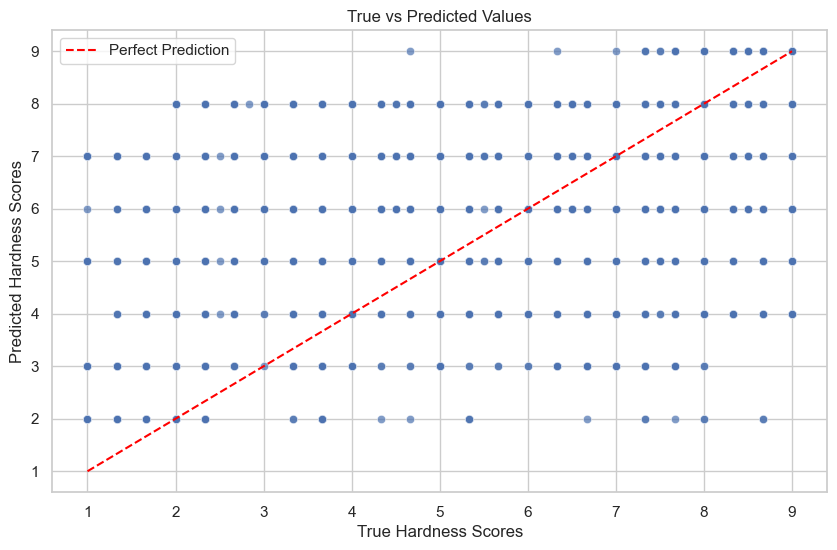

In [74]:
# True vs predicted plot
plot_true_vs_predicted(performance_df)


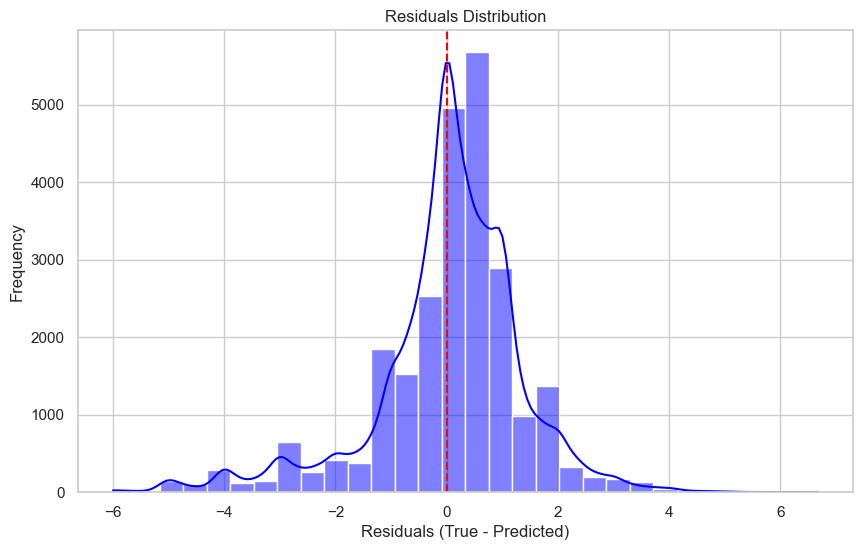

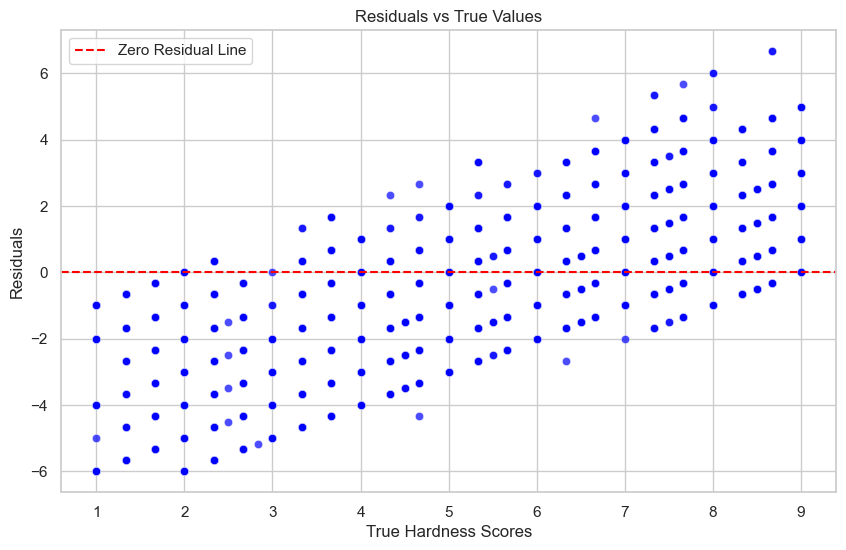

In [75]:
 # Residual plots
plot_residuals(performance_df)

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/1727979291.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Range', y='Error', data=performance_df, palette='viridis')


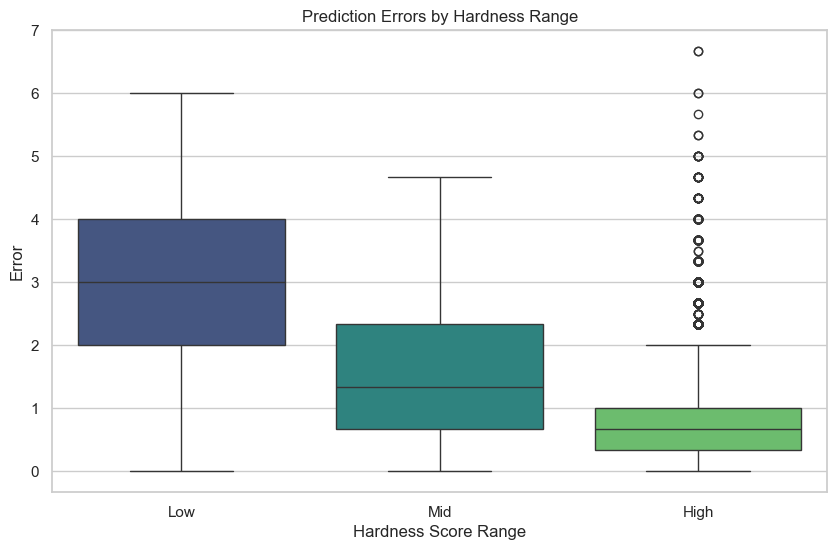

In [76]:
 # Box plot of errors by range
plot_error_by_range(performance_df)

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/1727979291.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


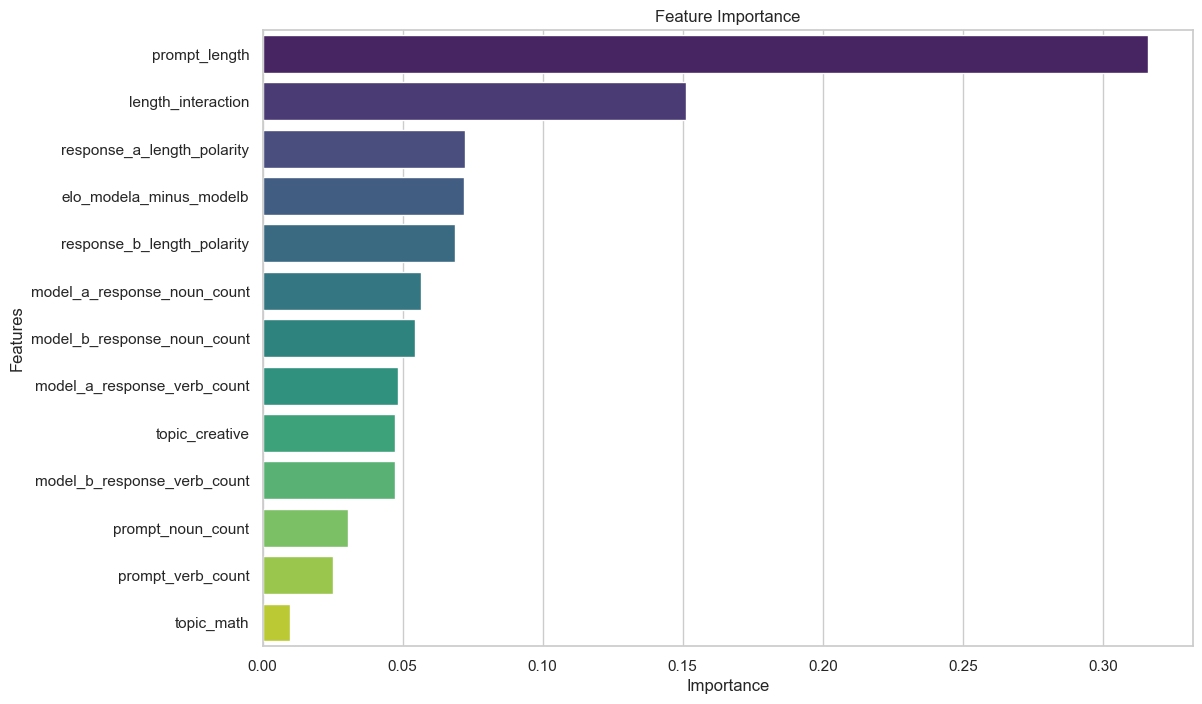

In [77]:

# Plot feature importance
plot_feature_importance(rf_model, selected_features)

Mean Squared Error (MSE): 1.84
Root Mean Squared Error (RMSE): 1.36
Mean Absolute Error (MAE): 0.93
R-squared: 0.38
Explained Variance Score: 0.38
Median Absolute Error: 0.67


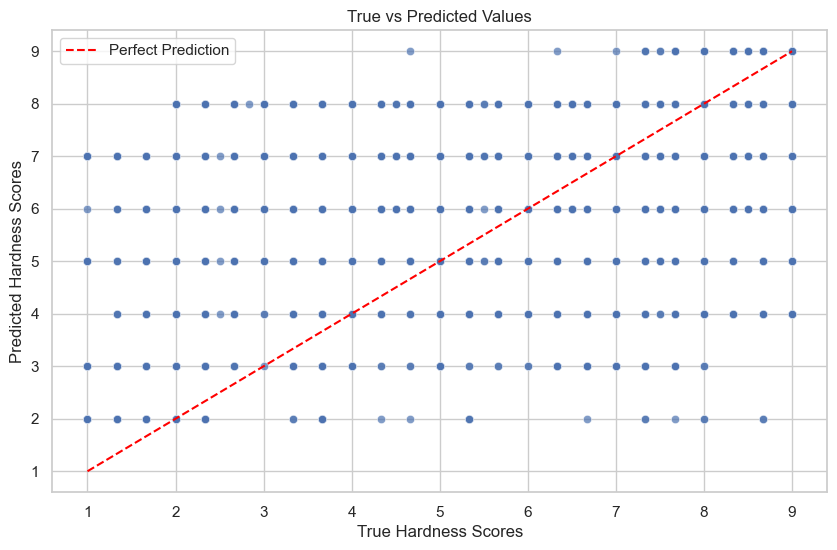

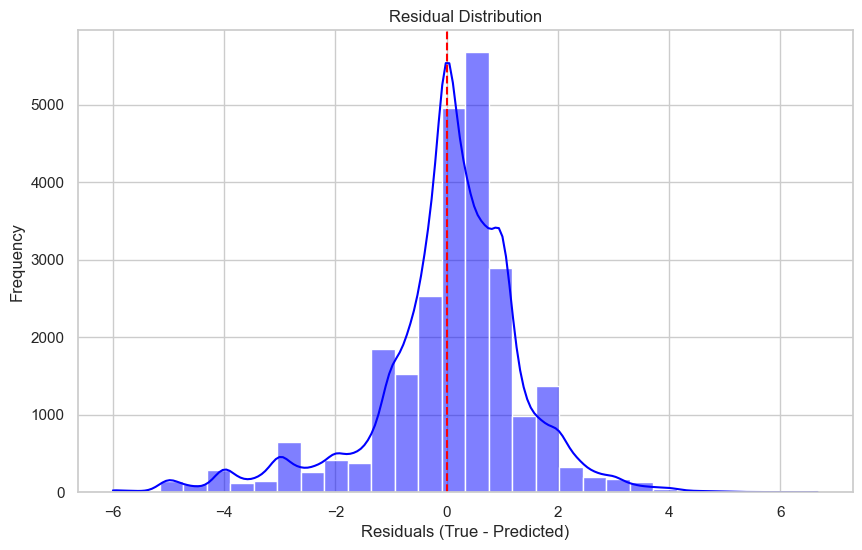

/var/folders/yl/05hmr43n3dsc2_4b4vkqgnj40000gn/T/ipykernel_97432/2931707800.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Range', y='Residuals', data=performance_df, palette='viridis')


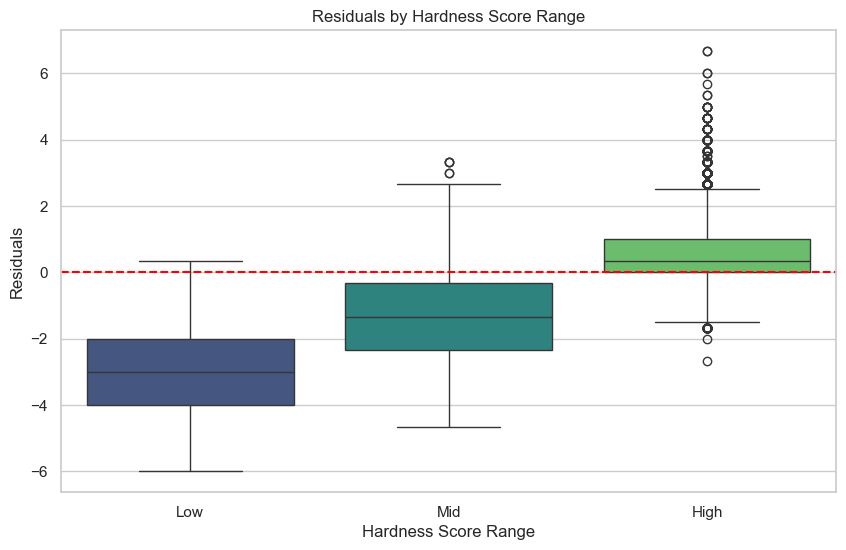

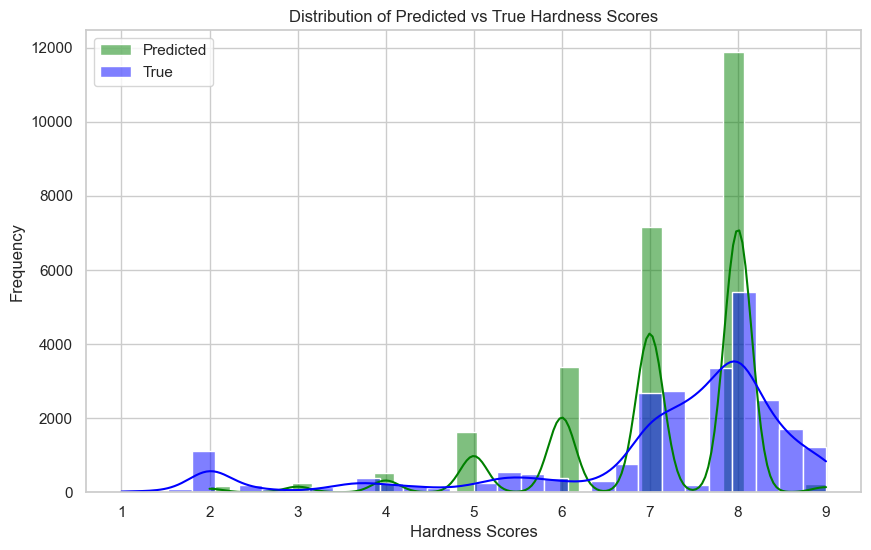

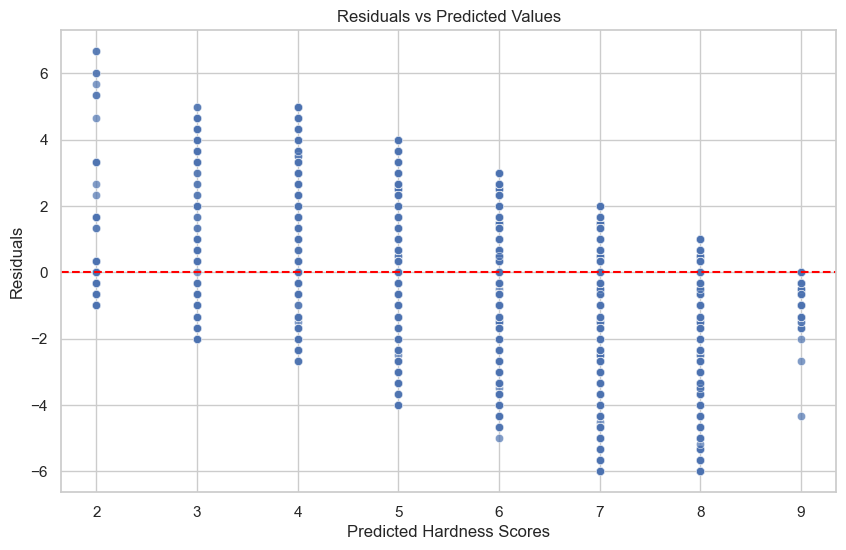

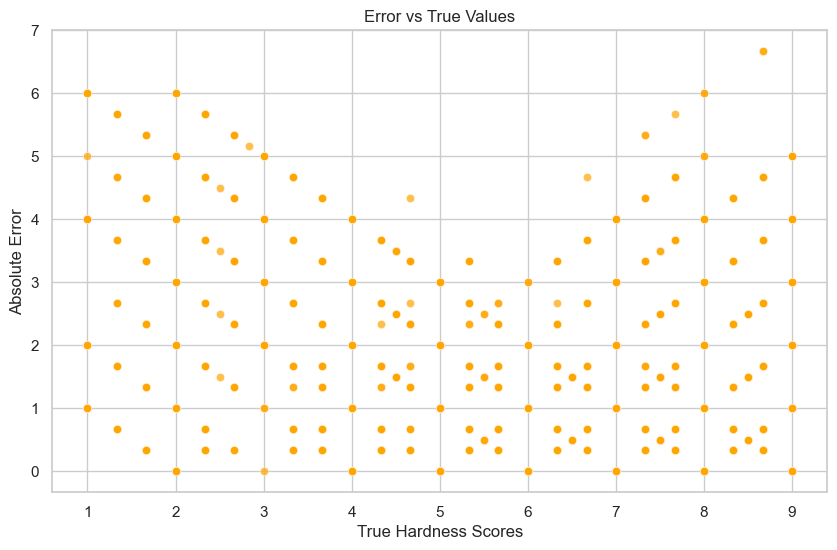

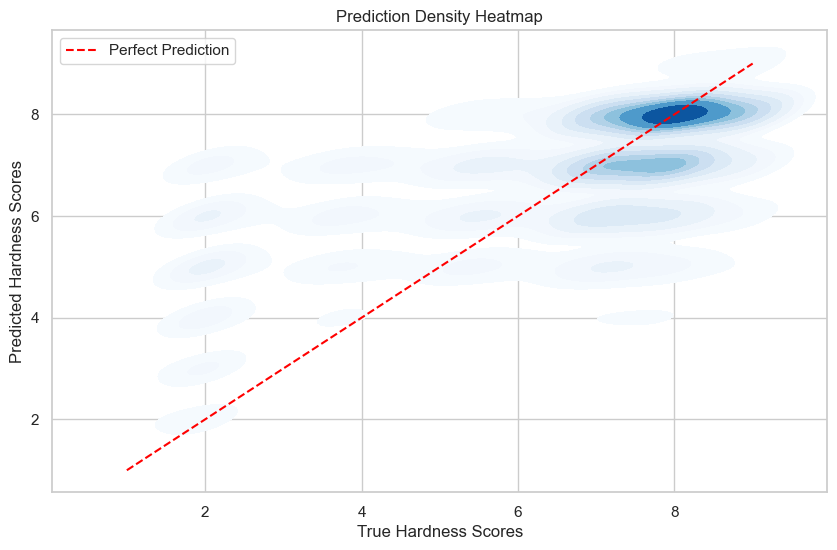

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    median_absolute_error,
)

# Ensure predicted values are rounded to integers
performance_df = pd.DataFrame({
    'True Values': y_true_all,
    'Predicted Values': y_pred_all
})
performance_df['Residuals'] = performance_df['True Values'] - performance_df['Predicted Values']

# Additional Performance Metrics
mse = mean_squared_error(performance_df['True Values'], performance_df['Predicted Values'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(performance_df['True Values'], performance_df['Predicted Values'])
r2 = r2_score(performance_df['True Values'], performance_df['Predicted Values'])
explained_var = explained_variance_score(performance_df['True Values'], performance_df['Predicted Values'])
median_abs_error = median_absolute_error(performance_df['True Values'], performance_df['Predicted Values'])

# Print Performance Metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Explained Variance Score: {explained_var:.2f}")
print(f"Median Absolute Error: {median_abs_error:.2f}")

# Scatter Plot: True vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=performance_df, alpha=0.7)
plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
         [performance_df['True Values'].min(), performance_df['True Values'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('True vs Predicted Values')
plt.xlabel('True Hardness Scores')
plt.ylabel('Predicted Hardness Scores')
plt.legend()
plt.show()

# Residual Plot
plt.figure(figsize=(10, 6))
sns.histplot(performance_df['Residuals'], kde=True, bins=30, color='blue')
plt.title('Residual Distribution')
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Box Plot: Residuals by Range
performance_df['Range'] = pd.cut(performance_df['True Values'], bins=[0, 3, 6, 10], labels=['Low', 'Mid', 'High'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='Range', y='Residuals', data=performance_df, palette='viridis')
plt.title('Residuals by Hardness Score Range')
plt.xlabel('Hardness Score Range')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Distribution of Predicted Values
plt.figure(figsize=(10, 6))
sns.histplot(performance_df['Predicted Values'], kde=True, bins=30, color='green', label='Predicted')
sns.histplot(performance_df['True Values'], kde=True, bins=30, color='blue', label='True', alpha=0.5)
plt.title('Distribution of Predicted vs True Hardness Scores')
plt.xlabel('Hardness Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Residuals vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=performance_df['Predicted Values'], y=performance_df['Residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Hardness Scores')
plt.ylabel('Residuals')
plt.show()

# Error vs True Values
performance_df['Error'] = np.abs(performance_df['True Values'] - performance_df['Predicted Values'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Error', data=performance_df, alpha=0.7, color='orange')
plt.title('Error vs True Values')
plt.xlabel('True Hardness Scores')
plt.ylabel('Absolute Error')
plt.show()

# Heatmap of Prediction Density
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=performance_df['True Values'],
    y=performance_df['Predicted Values'],
    cmap="Blues", fill=True
)
plt.plot([performance_df['True Values'].min(), performance_df['True Values'].max()],
         [performance_df['True Values'].min(), performance_df['True Values'].max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title('Prediction Density Heatmap')
plt.xlabel('True Hardness Scores')
plt.ylabel('Predicted Hardness Scores')
plt.legend()
plt.show()


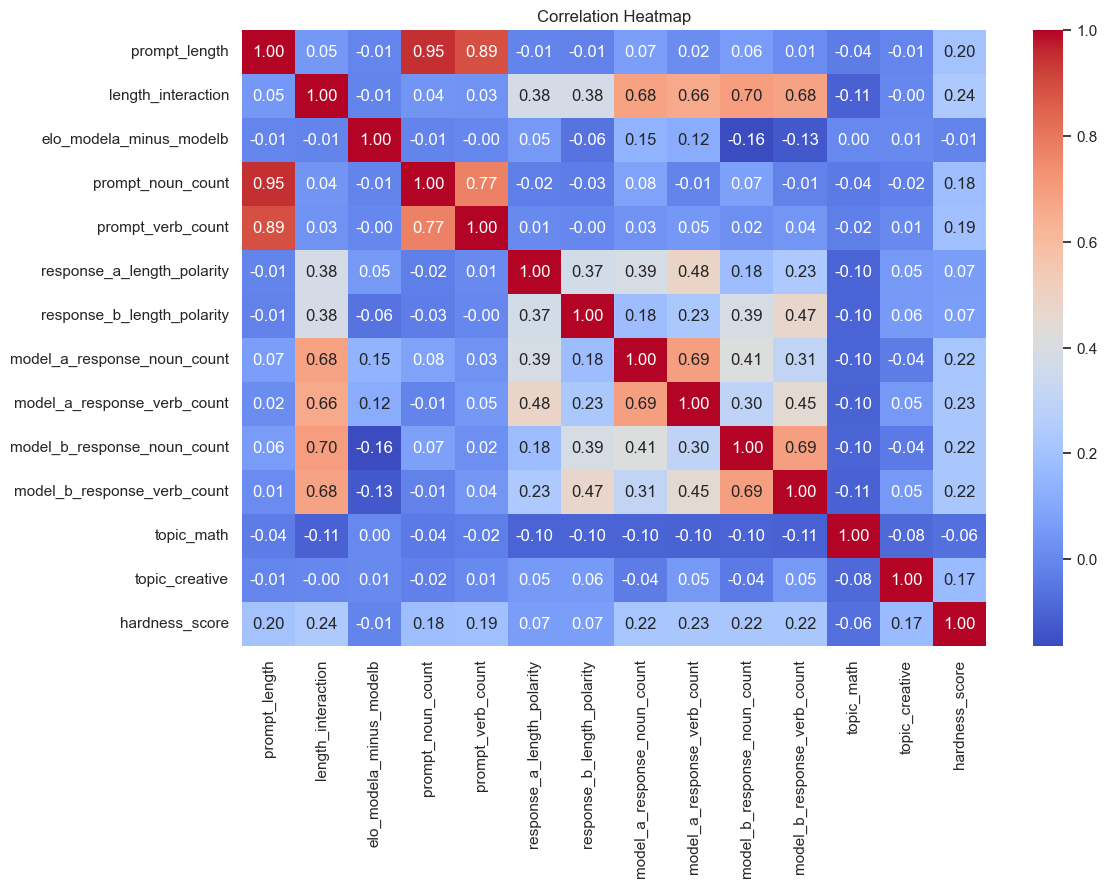

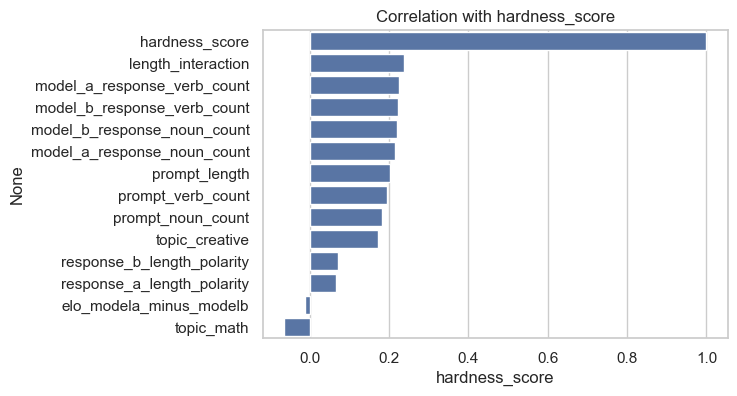

In [79]:
# Correlation Heatmap
def plot_correlation_heatmap(data, target_column):
    corr = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    
    # Correlation with target variable
    plt.figure(figsize=(6, 4))
    target_corr = corr[target_column].sort_values(ascending=False)
    sns.barplot(x=target_corr, y=target_corr.index)
    plt.title(f"Correlation with {target_column}")
    plt.show()

# Correlation heatmap (pass your filtered_df and target column name)
plot_correlation_heatmap(filtered_df[selected_features + ['hardness_score']], 'hardness_score')
